### Ejercicio Práctico - Clase 3 VPC2

1) Realizar transfer learning a partir de alguna de las siguientes redes: vgg11, resnet18, convnext_tiny preentrenadas, y entrenar sobre el dataset CIFAR10 contenido en PyTorch. Que puede concluir al compararlos con los resultados obtenidos en el entrenamiento de la tarea 2?

2) Realice el entrenamiento de la misma red seleccionada en el punto 1, sin partir de pesos preentrenados en esta oportunidad y sin congelar capas. A que resultados llega y como los explica?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchsummary

In [ ]:
!pip install torchmetrics
import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Carga del dataset CIFAR10, transformación y dataloader

In [ ]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(150, 150)),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                  ])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


#### Implementación de RESNET18 (preentrenada)

In [ ]:
resnet18_model = torchvision.models.resnet18(pretrained=True)

resnet18_model.to("cuda")

torchsummary.summary(resnet18_model, input_size=(3, 224, 224))
resnet18_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

#### Se congelan las capas

In [ ]:
for param in resnet18_model.parameters():
    param.requires_grad = False

#### Modifico la última capa (Linear). Por defecto, tendra `requires_grad = True`

In [ ]:
last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=10)

In [ ]:
optimizer_ft = torch.optim.Adam(resnet18_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

#### Función para entrenar el modelo (extraída del colab de clase)

In [ ]:
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):

    accuracy_metric = torchmetrics.Accuracy()

    if torch.cuda.is_available():
        model.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data)
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += accuracy_metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history

#### Se grafican los resultados obtenidos

In [ ]:
result_model, history = train(resnet18_model, criterion, optimizer_ft, train_loader, test_loader, 10)

Epoch: 1/10 - Train loss 1.213894 - Train Accuracy 0.640755 - Valid Loss 0.784303 - Valid Accuracy 0.761182
Epoch: 2/10 - Train loss 0.746791 - Train Accuracy 0.763736 - Valid Loss 0.653865 - Valid Accuracy 0.792432
Epoch: 3/10 - Train loss 0.663750 - Train Accuracy 0.781990 - Valid Loss 0.610968 - Valid Accuracy 0.798622
Epoch: 4/10 - Train loss 0.624948 - Train Accuracy 0.791367 - Valid Loss 0.590178 - Valid Accuracy 0.803514
Epoch: 5/10 - Train loss 0.605687 - Train Accuracy 0.794886 - Valid Loss 0.570529 - Valid Accuracy 0.809105
Epoch: 6/10 - Train loss 0.590995 - Train Accuracy 0.799164 - Valid Loss 0.563012 - Valid Accuracy 0.810703
Epoch: 7/10 - Train loss 0.583586 - Train Accuracy 0.800824 - Valid Loss 0.550197 - Valid Accuracy 0.813598
Epoch: 8/10 - Train loss 0.575804 - Train Accuracy 0.803723 - Valid Loss 0.541375 - Valid Accuracy 0.816094
Epoch: 9/10 - Train loss 0.565660 - Train Accuracy 0.806102 - Valid Loss 0.542012 - Valid Accuracy 0.815895
Epoch: 10/10 - Train loss 0.

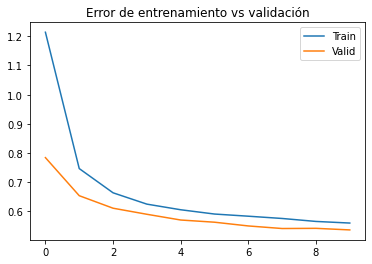

In [ ]:
plt.plot(history["train_loss"])
plt.plot(history["valid_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()

#### RESNET18 no preentrenada

In [ ]:
resnet18_model = torchvision.models.resnet18()

resnet18_model.to("cuda")

torchsummary.summary(resnet18_model, input_size=(3, 224, 224))
resnet18_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

#### Cambio el numero de salidas (clases)

In [ ]:
last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=10)

In [ ]:
optimizer_ft = torch.optim.Adam(resnet18_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

#### Se grafican los resultados obtenidos

In [ ]:
result_model_no_tl, history_no_tl = train(resnet18_model, criterion, optimizer_ft, train_loader, test_loader, 10)

Epoch: 1/10 - Train loss 1.232466 - Train Accuracy 0.552283 - Valid Loss 0.989225 - Valid Accuracy 0.649760
Epoch: 2/10 - Train loss 0.794597 - Train Accuracy 0.718510 - Valid Loss 0.791386 - Valid Accuracy 0.728634
Epoch: 3/10 - Train loss 0.575885 - Train Accuracy 0.800824 - Valid Loss 0.677827 - Valid Accuracy 0.769269
Epoch: 4/10 - Train loss 0.411576 - Train Accuracy 0.857266 - Valid Loss 0.651751 - Valid Accuracy 0.780851
Epoch: 5/10 - Train loss 0.267056 - Train Accuracy 0.908449 - Valid Loss 0.698983 - Valid Accuracy 0.779253
Epoch: 6/10 - Train loss 0.173756 - Train Accuracy 0.941939 - Valid Loss 0.786871 - Valid Accuracy 0.775859
Epoch: 7/10 - Train loss 0.125499 - Train Accuracy 0.957634 - Valid Loss 0.827364 - Valid Accuracy 0.781849
Epoch: 8/10 - Train loss 0.104716 - Train Accuracy 0.964711 - Valid Loss 0.760979 - Valid Accuracy 0.794928
Epoch: 9/10 - Train loss 0.090702 - Train Accuracy 0.968790 - Valid Loss 0.839107 - Valid Accuracy 0.788039
Epoch: 10/10 - Train loss 0.

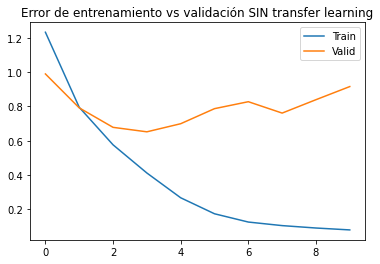

In [ ]:
plt.plot(history_no_tl["train_loss"])
plt.plot(history_no_tl["valid_loss"])
plt.title("Error de entrenamiento vs validación SIN transfer learning")
plt.legend(['Train', 'Valid'])
plt.show()

### Resumen

Se entrenó la red RESNET18 sobre el dataset CIFAR10.

En primer lugar, el entrenamiento se llevó a cabo con la red preentrenada y las capas congeladas, salvo la última capa lineal. En este caso se observa que el entrenamiento es mucho más rapido que al aplicar técnicas de data augmentation. Esto se debe, por un lado, a las mejoras intrínsecas que posee la RESNET18, y por el otro, a que el modelo ya se encuentra preentrenado. Es muy importante resaltar que, a pesar de que el dataset es el original, no se sobreentrena el modelo.

Luego se entrenó la RESNET18 sin preentrenar ni congelar capas. Se observa que la velocidad de aprendizaje es buena (por la arquitectura de la red) pero hay sobreentrenamiento ya que el modelo está constantemente aprendiendo del mismo set de datos.